# Recommendation System with Probabilistic Matrix Factorization

#### Weiwei Qi and Qimin Zhang

#### Department of Biostatisics, Columbia University

## Introduction

With the rise of streaming media and video websites like Netflix, recommendation systems are widely used to predict users' potential interests on the items. Behind these powerful systems are often state-of-art machine learning algorithms, including probabilistic matrix factorization, which performed extremely well in “Netflix Challenge”, a public data science challenge to predict users’ ratings for movies. [1] 

In this project, we specifically aim to apply probabilistic matrix factorization to solve this problem. There are two major challenges in performing such tasks. First, we are dealing with extremely high-dimensional data. Both the numbers of users and media could be very large. Second, missing data could bring us many troubles since users wouldn't rate all the media they'd seen. This will introduce more sparsity into the already sparse data. 

## Goals

1. To train PMF models to predict user-anime ratings

2. To compare different model performance under different assumptions

## Data

To build the predictive model, we gather user preference data on animes (hand-drawn and computer animation) from [Kaggle](https://www.kaggle.com/CooperUnion/anime-recommendations-database). 

As matrix factorization could be computationally heavy, we implement our idea on a small subset of data composed of 100 Users and 200 Anime. For Model training, we split our data with a train/test ratio of 9:1. 

In [1]:
import torch
import pyro
import numpy as np
from matplotlib import pyplot as plt
from utils import load_makematrix
from GaussianMF import run_gaussian_mf
from PoissonMF import run_poisson_mf
from visualization import *

k = 30

anime_data, anime_matrix_train, anime_data_test = load_makematrix("data/ratings_100_200_real.csv", split=True)

In [2]:
print(anime_matrix_train.shape)

(100, 200)


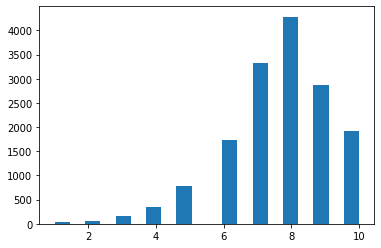

In [3]:
# Plot the distribution of ratings
plt.hist(anime_data.rating, bins=20)
plt.show()

In [4]:
print('The mean of ratings is', np.mean(anime_data[anime_data.rating > 0].rating))
print('The standard deviation of ratings is', np.std(anime_data[anime_data.rating > 0].rating))

The mean of ratings is 7.6670970240784975
The standard deviation of ratings is 1.5856381149038559


## Box's loop 1
### Model 1: Gaussian 

The idea of matrix factorization is to decompose the rating matrix into two latent features U and V with latent factor being a designated constant. We experimentally found out that a latent factor K between 20 and 30 is a sweet range for our purpose.

Ratings: $r_{ij} \subset [1, 10]$

$$
r_{ij} \sim \mathcal{N}(u^T_i v_j, \sigma^2)
$$


Users latent feature: $100\times 30$

Anime latent feature: $200\times 30$

In our first model, we assume that the user and anime latent feature are k-dimensional latent variable vectors distributed as:: 

$$
u_i \sim \mathcal{N}_k(0, I\sigma^2_u); \\\\ v_j \sim \mathcal{N}_k(0, I\sigma^2_v) 
$$

We also assume that $\sigma \sim \mathrm{Uniform}(0, 10)$; 

The predicted matrix is 

$$
\hat{R}_{m \times n} = U^T V
$$

The likelihood: 

$$
\ell(R|U,V,\sigma) = \prod_{i=1}^m\prod_{j=1}^n [\mathcal{N}(r_{ij}|u^T_i v_j, \sigma^2)]^{I_{ij}}
$$

where $I_{ij}=1$ if user i had rated anime j and 0 otherwise. 

The posterior should be:

$$
P(U,V,\sigma^2|R,\sigma^2_u,\sigma^2_v)
$$

### Inference on model 1

**MAP inference**

In [5]:
loss_list, mae_list = run_gaussian_mf(anime_matrix_train, anime_data_test, k = k, method="map", mae_tol = 0.05)

[iter 0]  loss: 88107957.1728 Test MAE: 7.6335
[iter 250]  loss: 9710353.9180 Test MAE: 7.6335
[iter 500]  loss: 9703657.6773 Test MAE: 7.6335
[iter 750]  loss: 9703656.7566 Test MAE: 7.6335


**Criticism**

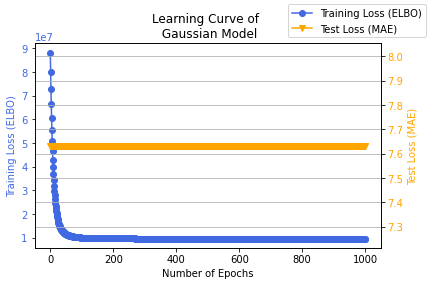

In [6]:
learning_curve_plot(loss_list, mae_list)

Due to the nature of MAP inference, the latent matrices U and V are sampled from Delta distribution, so they contain all zeros. Therefore our test loss can’t be successfully optimized. 

**SVI inference**

In [7]:
loss_list, mae_list = run_gaussian_mf(anime_matrix_train, anime_data_test, k = k, method = "svi", mae_tol = 0.02)

[iter 0]  loss: 168894882.5039 Test MAE: 7.6332
[iter 250]  loss: 5996485.3684 Test MAE: 0.9610
[iter 500]  loss: 4873891.0625 Test MAE: 0.8980
[stop at iter 504] loss: 4825559.0039 Test MAE: 0.9229


**SVI criticism**

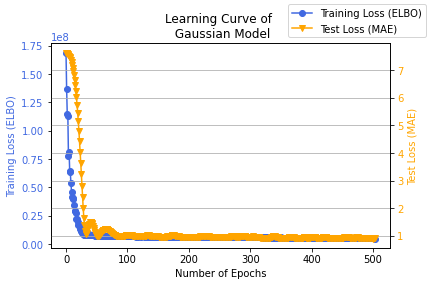

In [8]:
learning_curve_plot(loss_list, mae_list)

In [9]:
print('The MAE is', min(mae_list))

The MAE is 0.8980233973841514


The SVI method was performing well with test MAE minimized to be 0.90. 

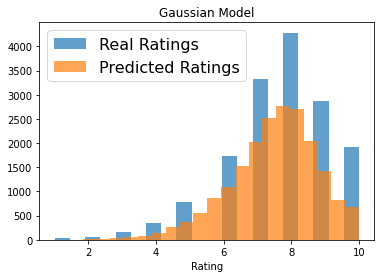

In [10]:
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
R[R>10] = 10
# Comparison between real & predicted ratings
hist_comparison(anime_data.rating, R.detach().numpy().flatten())

We can plot the distribution of predicted ratings for every user-anime pair. For Gaussian model, the predicted values are all continuous instead of integers, so the predicted distribution is more flat, but it mimics the real distribution quite well in terms of mode and skewness.

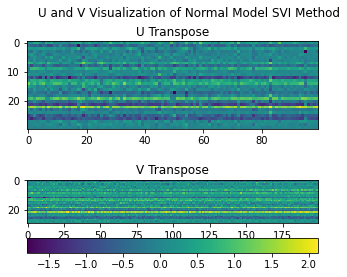

In [12]:
latent_viz()

If we consider the latent matrices U and V as images, then we could plot them out like this. We can’t exactly tell the meaning of this visualization, because they are the abstract representation of user features and anime features. 

## Box's loop 2
### Model 2: Poisson

With other things similar to model 1, we assume a difference distribution for ratings. Specifically, we assume that 

$$r_{ij} \sim \mathcal{Poisson} (u^T_i v_j)$$

$$
u_i \sim \mathcal{N}_k(0, I\sigma^2_u); \\\\ v_j \sim \mathcal{N}_k(0, I\sigma^2_v) 
$$

then the likelihood is: 

$$
\ell(R|U,V) = \prod_{i=1}^m\prod_{j=1}^n [\mathcal{Poisson}(r_{ij}|u^T_i v_j)]^{I_{ij}}
$$

where $I_{ij}=1$ if user i had rated anime j and 0 otherwise. So the posterior should be:

$$
P(U,V|R,\sigma^2_u,\sigma^2_v)
$$

### Inference on model 2

In [13]:
loss_list, mae_list = run_poisson_mf(anime_matrix_train, anime_data_test, k = k, n_steps=5000, mae_tol = 0.05)

[iter 0]  loss: 72030853.9433 Test MAE: 7.6334
[iter 250]  loss: 24241352.8189 Test MAE: 2.3326
[iter 500]  loss: 14026085.8527 Test MAE: 2.0957
[iter 750]  loss: 9950768.5740 Test MAE: 1.8152
[iter 1000]  loss: 9394501.5975 Test MAE: 1.5973
[iter 1250]  loss: 8396421.9601 Test MAE: 1.4682
[iter 1500]  loss: 7855552.5660 Test MAE: 1.3324
[iter 1750]  loss: 7085680.4448 Test MAE: 1.2498
[iter 2000]  loss: 7139019.4014 Test MAE: 1.1899
[iter 2250]  loss: 6699108.2877 Test MAE: 1.1367
[iter 2500]  loss: 6555851.5182 Test MAE: 1.1061
[iter 2750]  loss: 6344575.6580 Test MAE: 1.0874
[iter 3000]  loss: 6240122.3637 Test MAE: 1.0622
[iter 3250]  loss: 6035576.5384 Test MAE: 1.0381
[iter 3500]  loss: 5971576.4964 Test MAE: 1.0023
[iter 3750]  loss: 5966885.5471 Test MAE: 0.9898
[iter 4000]  loss: 5881193.2099 Test MAE: 0.9886
[iter 4250]  loss: 5851481.6377 Test MAE: 0.9547
[iter 4500]  loss: 5807350.2508 Test MAE: 0.9522
[iter 4750]  loss: 5780740.9340 Test MAE: 0.9382


**SVI criticism**

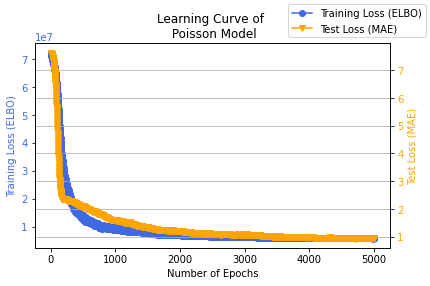

In [18]:
learning_curve_plot(loss_list, mae_list, title="Learning Curve of \n Poisson Model")

It took 5000 steps to train the Poisson model while it only took 500 for Gaussian model.

In [19]:
print('The MAE is', min(mae_list))

The MAE is 0.9343253657125657


The test MAE was minimized to be 0.93, which is very close to 0.90 for Gaussian model.

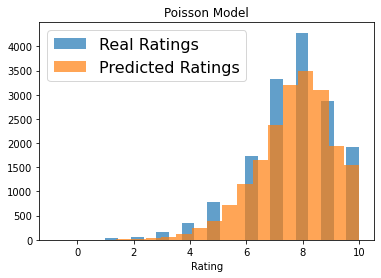

In [20]:
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
R[R>10] = 10
# Comparison between real & predicted ratings
hist_comparison(anime_data.rating, R.detach().numpy().flatten(), title="Poisson Model")

For our Poisson model, the predicted ratings are expected to be close to integers sampled from a poisson distribution, so the predicted distribution is thinner and closer to the true distribution.

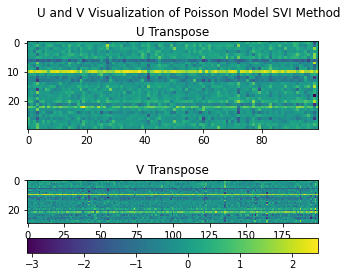

In [21]:
latent_viz(title = "U and V Visualization of Poisson Model SVI Method")

## Conclusions

1. Probabilistic matrix factorization is efficient in predicting users’ preference for items with limited information. Traditional machine learning algorithms take many other information into account. However, without those information, probabilistic matrix factorization is able to “extract” latent users’ and animes’ features and utilize them for prediction. 

2. Through our two Box Loops, we found the Gaussian model performs better for this project, and it took significantly less steps to converge. However, the performances of two models are close (0.90 versus 0.93).

3. The MAP solution is not well obtained in our current models. Our test on PMF with pytorch indicates that it should be able to obtain MAP estimation and use it for MCMC subsequently. 

4. We experimentally found out that adopting the variance of ratings as a prior could increase the model performance on the testset compared to a fixed sigma. We anticipate that a fixed variance parameter would bias the posterior towards the training data.  

## Discussion

1. Much more steps for Poisson model (5000) to converge than Gaussian (500). Our guess is that the “real” distribution is closer to Gaussian, because the real distribution is a little bit left-skewed, but Poisson distribution is often right-skewed. When training the Poisson model, the algorithm is trying to mimic a left-skewed distribution, and that’s the reason to take much more steps.

2. The latent variables we have are some abstract matrices, although plotted as images, are still very hard to interpret.

3. MCMC in matrix factorization could be hard as the Gaussian priors may introduce symmetries in the posterior and reduce the efficiency of MCMC sampling. In our experiment, the MCMC is indeed very slow and it took 45 hours to finish 600 steps out of a total 1200 steps. Additionally, we didn't obtain a useful MAP solution, therefore the MCMC cannot be initialized by it [2]. 

![MCMC](mcmc.png)

4. 20% of the original ratings are watched-but-unrated. We believe this is a common scenario when building recommendation system. We believe the information it contains is worth exploring. 

5. Another view is to think of the left-skewed distribution as a normal distribution with its right tail cut at 10. When we added such constraints in both our gaussian and poisson model, they turn out to help our models' training process more “smooth” and “normal”. 

## Future Work

1. Adopt bayes probabilistic matrix factorization with gibbs sampling. We want to start by revising our current code for MAP solution and then use it to start MCMC inference. 

2. Since we have the estimates from matrix factorization, we want to further extend our results to classification. For example, we can set up a model with the estimates we have as the new prior for bayes classification. As users tend to have different rating standards, we want to see if it is possible to build a classification model based on lantent features.  

3. Currently we have a workable pytorch script that implements PMF on our large dataset with 6 million ratings. This script is adapted from matlab script by Salakhutdinov [2]. We want to further build a large scale pyro version based on our current attempt. 

## References

[1] Blei, D. M. (2014). Build, compute, critique, repeat: Data analysis with latent variable models. 

[2] Mnih, A., & Salakhutdinov, R. R. (2008). Probabilistic matrix factorization. In Advances in neural information processing systems (pp. 1257-1264).

[3] Box, G. E. (1976). Science and statistics. Journal of the American Statistical Association, 71(356), 791-799. 